In [1]:
!pip install seaborn

Shape of Q: (1, 4, 8)
Shape of K: (1, 4, 8)
Shape of V: (1, 4, 8)


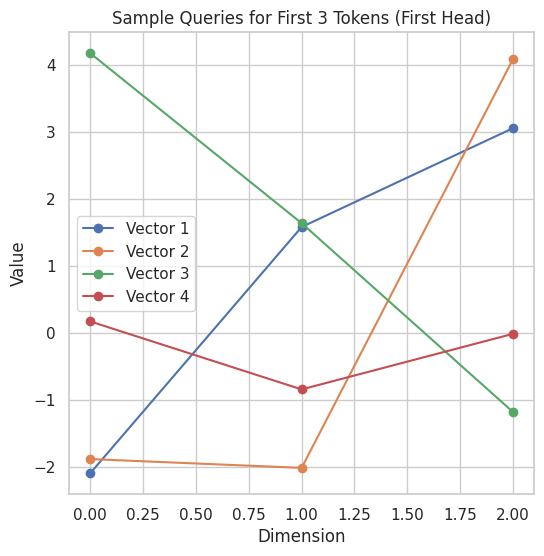

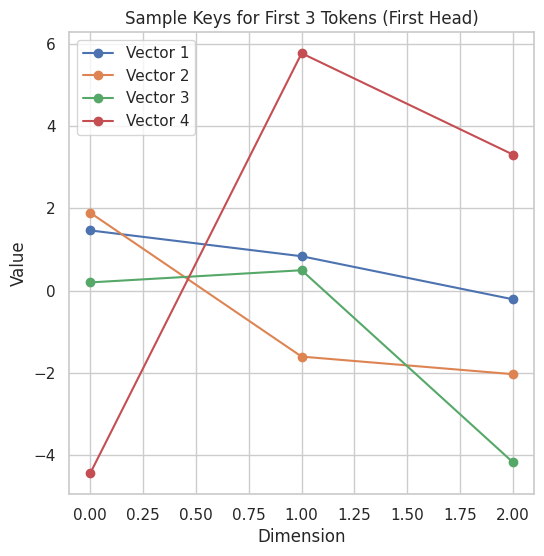

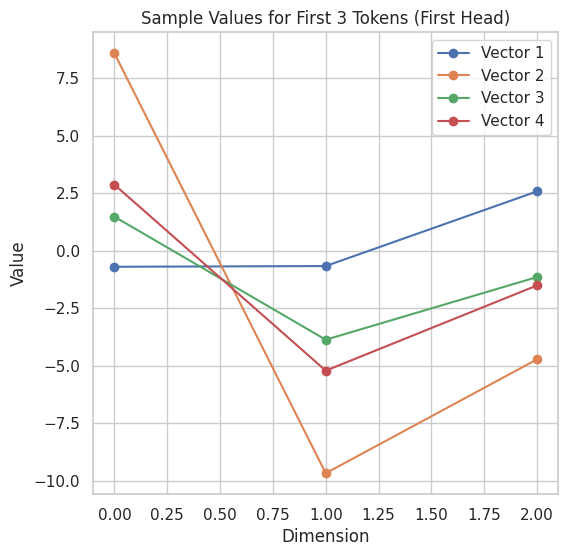

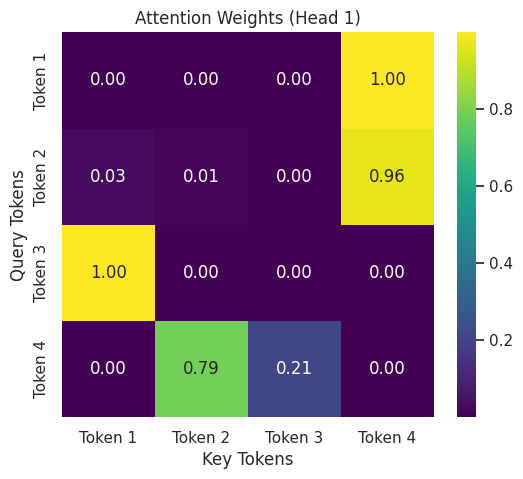

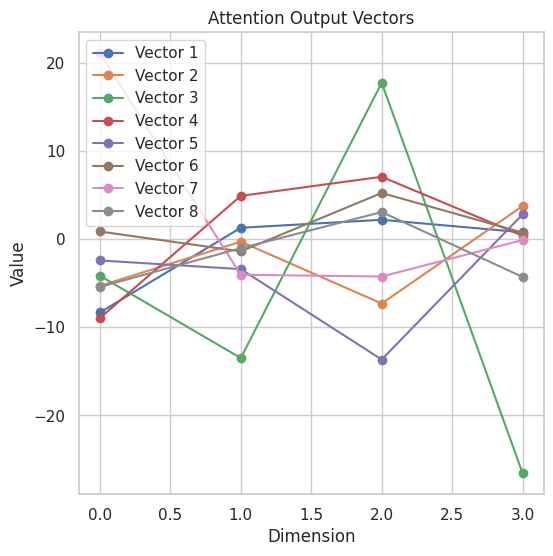

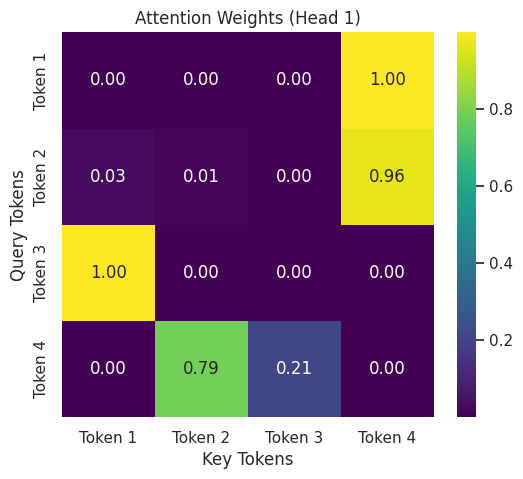

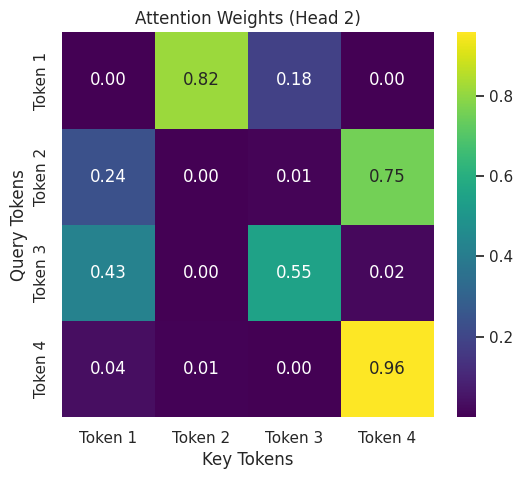

Attention Weights Statistics:
Head 1:
 - Mean: 0.2500
 - Variance: 0.1617

Head 2:
 - Mean: 0.2500
 - Variance: 0.1078



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# -----------------------------
# Helper Functions for Visualization
# -----------------------------

def plot_matrix(matrix, title, xlabel, ylabel, xticks=None, yticks=None, figsize=(6,5)):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap='viridis',
                xticklabels=xticks, yticklabels=yticks)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_vectors(vectors, title, labels, figsize=(6,6)):
    """
    Plot a set of vectors with a given title and labels.
    """
    plt.figure(figsize=figsize)
    num_vectors = len(vectors)
    num_labels = len(labels)
    
    # Ensure labels match the number of vectors
    if num_vectors != num_labels:
        print(f"Warning: Number of vectors ({num_vectors}) does not match the number of labels ({num_labels}).")
        labels = [f"Vector {i+1}" for i in range(num_vectors)]
        
    for i, vector in enumerate(vectors):
        plt.plot(vector, label=labels[i], marker='o')
    plt.title(title)
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# -----------------------------
# Transformer Attention Components
# -----------------------------

class TransformerAttention:
    def __init__(self, embed_size, num_heads):
        assert embed_size % num_heads == 0, "Embedding size must be divisible by number of heads."
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads
        
        # Initialize weights for Query, Key, Value
        self.W_q = np.random.randn(embed_size, embed_size)
        self.W_k = np.random.randn(embed_size, embed_size)
        self.W_v = np.random.randn(embed_size, embed_size)
        
        # Output weight
        self.W_o = np.random.randn(embed_size, embed_size)
        
    def split_heads(self, x):
        """
        Split the embedding into multiple heads
        """
        batch_size, seq_length, embed_size = x.shape
        x = x.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        return x.transpose(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, head_dim)
    
    def scaled_dot_product_attention(self, Q, K, V):
        """
        Compute scaled dot-product attention
        """
        d_k = Q.shape[-1]
        scores = np.matmul(Q, K.transpose(0,1,3,2)) / np.sqrt(d_k)  # (batch_size, num_heads, seq_length, seq_length)
        
        # Apply softmax
        attention_weights = self.softmax(scores, axis=-1)
        
        # Weighted sum of V
        output = np.matmul(attention_weights, V)  # (batch_size, num_heads, seq_length, head_dim)
        return output, attention_weights
    
    def softmax(self, x, axis=-1):
        """
        Compute softmax along the specified axis
        """
        x_exp = np.exp(x - np.max(x, axis=axis, keepdims=True))
        return x_exp / np.sum(x_exp, axis=axis, keepdims=True)
    
    def forward(self, x):
        """
        Forward pass through the attention mechanism
        """
        batch_size, seq_length, embed_size = x.shape
        
        # Linear projections
        Q = np.matmul(x, self.W_q)  # (batch_size, seq_length, embed_size)
        K = np.matmul(x, self.W_k)
        V = np.matmul(x, self.W_v)
        
        # Debug: Print shapes of Q, K, V
        print(f"Shape of Q: {Q.shape}")
        print(f"Shape of K: {K.shape}")
        print(f"Shape of V: {V.shape}")
        
        # Visualize Queries, Keys, Values for first head
        plot_vectors(Q[0,0:3,0:4].T, 
                    title="Sample Queries for First 3 Tokens (First Head)",
                    labels=[f"Q{i+1}" for i in range(3)])
        plot_vectors(K[0,0:3,0:4].T, 
                    title="Sample Keys for First 3 Tokens (First Head)",
                    labels=[f"K{i+1}" for i in range(3)])
        plot_vectors(V[0,0:3,0:4].T, 
                    title="Sample Values for First 3 Tokens (First Head)",
                    labels=[f"V{i+1}" for i in range(3)])
        
        # Split into heads
        Q = self.split_heads(Q)  # (batch_size, num_heads, seq_length, head_dim)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Compute attention
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V)
        
        # Visualize Attention Weights for first head
        plot_matrix(attention_weights[0,0], 
                   title="Attention Weights (Head 1)",
                   xlabel="Key Tokens",
                   ylabel="Query Tokens",
                   xticks=[f"Token {i+1}" for i in range(seq_length)],
                   yticks=[f"Token {i+1}" for i in range(seq_length)])
        
        # Concatenate heads
        attention_output = attention_output.transpose(0,2,1,3).reshape(batch_size, seq_length, self.embed_size)
        
        # Final linear layer
        output = np.matmul(attention_output, self.W_o)  # (batch_size, seq_length, embed_size)
        
        return output, attention_weights

# -----------------------------
# Demonstration and Visualization
# -----------------------------

def main():
    # Sample data: batch_size=1, seq_length=4, embed_size=8
    np.random.seed(42)  # For reproducibility
    batch_size = 1
    seq_length = 4
    embed_size = 8
    num_heads = 2
    
    # Random input embeddings
    x = np.random.randn(batch_size, seq_length, embed_size)
    
    # Initialize Transformer Attention
    attention = TransformerAttention(embed_size=embed_size, num_heads=num_heads)
    
    # Forward pass
    output, attention_weights = attention.forward(x)
    
    # Visualize Output
    plot_vectors(output[0].T, 
                title="Attention Output Vectors",
                labels=[f"Token {i+1}" for i in range(seq_length)])
    
    # Visualize Attention Weights for all heads
    for head in range(num_heads):
        plot_matrix(attention_weights[0,head], 
                   title=f"Attention Weights (Head {head+1})",
                   xlabel="Key Tokens",
                   ylabel="Query Tokens",
                   xticks=[f"Token {i+1}" for i in range(seq_length)],
                   yticks=[f"Token {i+1}" for i in range(seq_length)])

    # Statistical Analysis
    print("Attention Weights Statistics:")
    for head in range(num_heads):
        weights = attention_weights[0, head]
        print(f"Head {head+1}:")
        print(f" - Mean: {weights.mean():.4f}")
        print(f" - Variance: {weights.var():.4f}")
        print()

if __name__ == "__main__":
    main()
